In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.regularizers import l2

picture_size = 56
folder_path = "../input/face-expression-recognition-dataset/images/"

In [27]:
batch_size  = 32
verbose = 1
patience = 50

datagen_train  = ImageDataGenerator(rescale = 1.0/255.0,
                                  width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

datagen_val = ImageDataGenerator(rescale= 1.0/255)

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)
l2_regularization=0.01
regularization = l2(l2_regularization)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [28]:
import tensorflow as tf
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def squeeze_excite_block(inputs, ratio=4):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = Multiply()([init, se])
    return x

num_classes = 7
def conv_block(x, n_filter):

    x = Conv2D(n_filter, (3, 3), padding="same", kernel_regularizer=regularization)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = squeeze_excite_block(x)
    
    return x


def dense_block(x, n_filters):
    x = Dense(n_filters)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    return x

def dense_block_soft(x, n_filters):
    x = Dense(n_filters)(x)
    x = Activation("softmax")(x)
    
    return x


class vgg16:
    def __init__(self, input_size=56):
        self.input_size = input_size
        
    def build_model(self):
        n_filters = [64, 128, 256, 512]
        inputs = Input((self.input_size, self.input_size, 1))
        c0 = inputs
        c1 = conv_block(c0, n_filters[0])
        c2 = conv_block(c1, n_filters[1])
        c3 = conv_block(c2, n_filters[2])
        c4 = conv_block(c3, n_filters[3])
        
        c5 = Flatten()(c4)
        
        n_filters = [1024, 512, 7]
        c6 = dense_block(c5, n_filters[0])
        c7 = dense_block(c6, n_filters[1])
        outputs = dense_block_soft(c7, n_filters[2])

#         model = Dense(num_classes, activation = 'softmax')(c7)
        model = Model(inputs, outputs)
        
        return model

In [29]:
image_size = 56
arch = vgg16(input_size=image_size)
model = arch.build_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 56, 56, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 56, 56, 64)   640         input_6[0][0]                    
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 56, 56, 64)   0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 56, 56, 64)   256         activation_31[0][0]              
____________________________________________________________________________________________

In [30]:

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [32]:
epochs = 50

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau


checkpoint = ModelCheckpoint("SE-vgg16.h5", monitor='val_accracy', verbose=1, save_best_only=True, mode='max')

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=int(patience/4), verbose=1)
callbacks_list = [checkpoint, reduce_learningrate]

callbacks_list = [checkpoint, reduce_learningrate]
history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
900/900 [==============================] - 198s 214ms/step - loss: 7.6824 - accuracy: 0.2506 - val_loss: 5.8665 - val_accuracy: 0.4048
Epoch 2/50
900/900 [==============================] - 63s 70ms/step - loss: 5.4517 - accuracy: 0.3839 - val_loss: 4.1804 - val_accuracy: 0.4501
Epoch 3/50
900/900 [==============================] - 63s 70ms/step - loss: 3.9108 - accuracy: 0.4364 - val_loss: 3.1598 - val_accuracy: 0.4638
Epoch 4/50
900/900 [==============================] - 63s 70ms/step - loss: 2.9535 - accuracy: 0.4644 - val_loss: 2.4676 - val_accuracy: 0.4987
Epoch 5/50
900/900 [==============================] - 63s 70ms/step - loss: 2.3642 - accuracy: 0.4932 - val_loss: 2.0082 - val_accuracy: 0.5537
Epoch 6/50
900/900 [==============================] - 62s 69ms/step - loss: 2.0067 - accuracy: 0.5144 - val_loss: 1.9364 - val_accuracy: 0.5018
Epoch 7/50
900/900 [==============================] - 62s 69ms/step - loss: 1.7882 - accuracy: 0.5356 - val_loss: 1.7411 - val_accurac

In [34]:
model.save("./vggsenetwork.h5") 


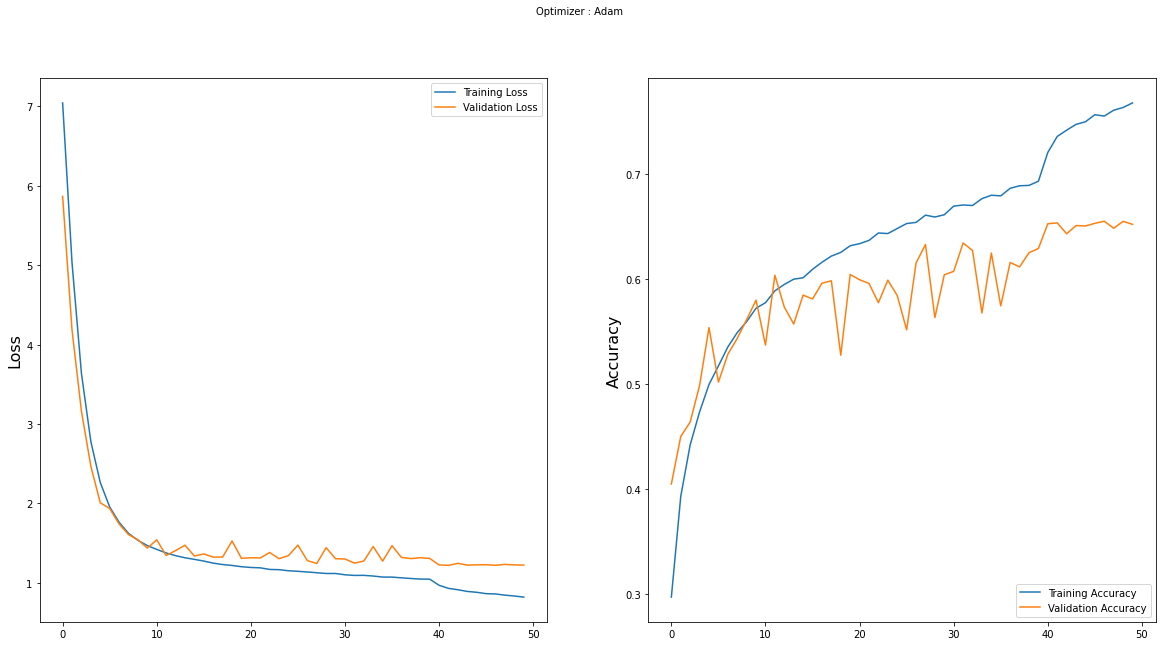

In [33]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()